In [2]:
import numpy as np
import pandas as pd

from imblearn.over_sampling import SMOTE

from sklearn.discriminant_analysis import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score, roc_auc_score, precision_score, recall_score
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import cross_val_score, train_test_split, HalvingGridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

from xgboost import XGBClassifier

import plotly.graph_objs as go
import plotly.express as ex

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

## Carregando o dataset

In [3]:
df = pd.read_csv('data/tuberculose_imputed.csv')
# Codificação de variáveis categóricas
# reg_not (0 = Norte, 1 = Nordeste, 2 = Sul, 3 = Sudeste, 4 = Centro-Oeste)
# cs_sexo (0 = Feminino, 1 = Masculino)
# cs_raca (0 = Branco, 1 = Preto, Pardo, Amarelo, Indígena)
# cs_escol_n (0 = 5- anos, 1 = 5-8 anos, 2 = 9-11 anos, 3 = 12+ anos)
# tratamento (0 = Caso novo, 1 = Retratamento (recidivo ou reingresso após abandono))
# raiox_tora (0 = Normal, 1 = Suspeito, 2 = Não realizado)
# agravaids (0 = Não, 1 = Sim)
# agravalcoo (0 = Não, 1 = Sim)
# agravdiabe (0 = Não, 1 = Sim)
# agravdoenc (0 = Não, 1 = Sim)
# hiv (0 = Negativo, 1 = Positivo, 2 = Não realizado)
# tratsup_at (0 = Não, 1 = Sim)
# benef_gov (0 = Não, 1 = Sim)
# agravdroga (0 = Não, 1 = Sim)
# agravtabac (0 = Não, 1 = Sim)
# abandono (0 = Não, 1 = Sim)
df.head()

,reg_not,cs_sexo,cs_raca,cs_escol_n,tratamento,raiox_tora,agravaids,agravalcoo,agravdiabe,agravdoenc,hiv,tratsup_at,benef_gov,agravdroga,agravtabac,idade,abandono
0,4,1,1,1,1,0,0,1,0,0,0,1,0,0,1,60,0
1,1,1,1,0,1,1,0,1,0,0,2,0,0,1,1,37,1
2,2,1,1,0,1,2,0,0,0,0,2,0,0,1,1,22,1
3,2,1,1,1,1,1,0,1,0,0,0,1,0,1,1,37,0
4,3,1,1,1,0,1,0,1,0,0,0,1,1,1,1,22,1


In [4]:
# Otimização de memória
for column in df.columns:
    df[column] = df[column].astype(np.int8)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243726 entries, 0 to 243725
Data columns (total 17 columns):
 #   Column      Non-Null Count   Dtype
---  ------      --------------   -----
 0   reg_not     243726 non-null  int8 
 1   cs_sexo     243726 non-null  int8 
 2   cs_raca     243726 non-null  int8 
 3   cs_escol_n  243726 non-null  int8 
 4   tratamento  243726 non-null  int8 
 5   raiox_tora  243726 non-null  int8 
 6   agravaids   243726 non-null  int8 
 7   agravalcoo  243726 non-null  int8 
 8   agravdiabe  243726 non-null  int8 
 9   agravdoenc  243726 non-null  int8 
 10  hiv         243726 non-null  int8 
 11  tratsup_at  243726 non-null  int8 
 12  benef_gov   243726 non-null  int8 
 13  agravdroga  243726 non-null  int8 
 14  agravtabac  243726 non-null  int8 
 15  idade       243726 non-null  int8 
 16  abandono    243726 non-null  int8 
dtypes: int8(17)
memory usage: 4.0 MB


## Separando conjuntos de treino e teste

In [5]:
# Separando variáveis independentes e dependentes
X = df.drop('abandono', axis=1)
y = df['abandono']

# Dividindo os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=42)
print(X_train.shape, X_test.shape)

(170608, 16) (73118, 16)


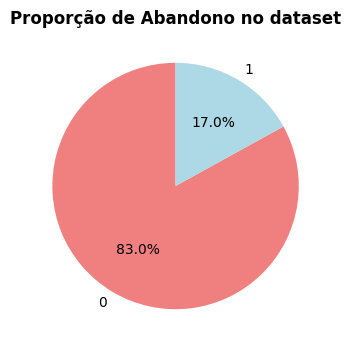

In [26]:
counts = df['abandono'].value_counts()

# Plotar o gráfico de pizza
plt.figure(figsize=(4, 4))
plt.pie(counts, labels=['0', '1'], autopct='%1.1f%%', startangle=90, colors=['lightcoral', 'lightblue'])
plt.title('Proporção de Abandono no dataset', fontweight='bold')
plt.show()

O dataset é desbalanceado, portanto devemos levar isso em conta no treinamento dos modelos. Faremos, primeiramente, validação cruzada usando `StratifiedKFold`, no qual os dados são estratificados de acordo com as classes. Depois, a outra estratégia será balancear o conjunto de treino usando a técnica de oversampling SMOTE e realizar validação cruzada com ele. Por fim, vamos comparar os resultados para saber qual será a melhor forma de lidar com o dataset desbalanceado.

In [6]:
oversample = SMOTE()
X_train_resh, y_train_resh = oversample.fit_resample(X_train, y_train)
print(X_train_resh.shape)

(283288, 16)


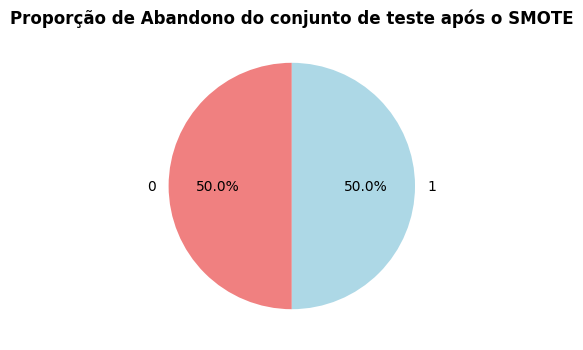

In [29]:
upsampled_df = pd.concat([X_train_resh, y_train_resh], axis=1)
counts = upsampled_df['abandono'].value_counts()

# Plotar o gráfico de pizza
plt.figure(figsize=(4, 4))
plt.pie(counts, labels=['0', '1'], autopct='%1.1f%%', startangle=90, colors=['lightcoral', 'lightblue'])
plt.title('Proporção de Abandono do conjunto de teste após o SMOTE', fontweight='bold')
plt.show()

## Testando modelos

Inicialmente, definiremos pipelines para os seguintes modelos: Random Forest, Regressão Logística, Naive Bayes Gaussiano, KNN e XGBoost.

In [5]:
rf_pipeline = Pipeline(steps = [('scale',StandardScaler()),('classifier',RandomForestClassifier(random_state=42))])
logreg_pipeline = Pipeline(steps = [('scale',StandardScaler()),('classifier',LogisticRegression(random_state=42))])
gaussianNB_pipeline = Pipeline(steps = [('scale',StandardScaler()),('classifier',GaussianNB())])
knn_pipeline = Pipeline(steps = [('scale',StandardScaler()),('classifier',KNeighborsClassifier(n_neighbors=5))])
xgb_pipeline = Pipeline(steps = [('scale',StandardScaler()),('classifier',XGBClassifier(random_state=42))])

Validação cruzada com `StratifiedKFold` no dataset original:

In [8]:
def evaluate_pipelines_cv_strat(pipelines, X, y, n_splits=5):
    # Configurar o StratifiedKFold
    cross_val_strat = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=32)
    
    results = {}
    # Avaliar cada pipeline
    for name, pipeline in pipelines.items():
        accuracies = []
        recalls = []
        f1s = []
        for train_index, test_index in cross_val_strat.split(X, y):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]
            
            # Treinar o pipeline
            pipeline.fit(X_train, y_train)
            
            # Fazer predições e avaliar o pipeline
            y_pred = pipeline.predict(X_test)
            accuracy = accuracy_score(y_test, y_pred)
            recall = recall_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)

            accuracies.append(accuracy)
            recalls.append(recall)
            f1s.append(f1)
        
        # Guardar as acurácias
        results[name] = {'accuracy' : np.mean(accuracies),
                         'recall' : np.mean(recalls),
                         'f1' : np.mean(f1s)}
    
    return results

pipelines = {
    'LR': logreg_pipeline,
    'RF': rf_pipeline,
    'NB': gaussianNB_pipeline,
    'KNN': knn_pipeline,
    'XGB': xgb_pipeline
}

# Avaliar os modelos usando StratifiedKFold
results = evaluate_pipelines_cv_strat(pipelines, X, y)

# Resultados
for name, result in results.items():
    print(f'{name}:')
    print(f'Accuracy mean: {result['accuracy']:.4f}')
    print(f'Recall mean: {result['recall']:.4f}')
    print(f'F1 mean: {result['f1']:.4f}')


LR:
Accuracy mean: 0.8401
Recall mean: 0.1735
F1 mean: 0.2692
RF:
Accuracy mean: 0.8451
Recall mean: 0.3776
F1 mean: 0.4529
NB:
Accuracy mean: 0.7725
Recall mean: 0.4879
F1 mean: 0.4213
KNN:
Accuracy mean: 0.8321
Recall mean: 0.3191
F1 mean: 0.3922
XGB:
Accuracy mean: 0.8416
Recall mean: 0.2020
F1 mean: 0.3021


Percebe-se que os modelos apresentam acurácias relativamente altas, porém valores de recall baixos. Portanto, conclui-se que os modelos acertam muitos casos de Não-Abandono, simplesmente por ser a classe majoritária do dataset, mas são ruins para classificar Abandono.  
Agora, vamos testar a validação cruzada com o conjunto de treino balanceado com SMOTE.

In [68]:
rf_cv_acc = cross_val_score(rf_pipeline,X_train_resh,y_train_resh,cv=5,scoring='accuracy')
logreg_cv_acc = cross_val_score(logreg_pipeline,X_train_resh,y_train_resh,cv=5,scoring='accuracy')
gaussian_cv_acc = cross_val_score(gaussianNB_pipeline,X_train_resh,y_train_resh,cv=5,scoring='accuracy')
knn_cv_acc = cross_val_score(knn_pipeline,X_train_resh,y_train_resh,cv=5,scoring='accuracy')
xgb_cv_acc = cross_val_score(xgb_pipeline,X_train_resh,y_train_resh,cv=5,scoring='accuracy')

In [69]:
print('Média das acurácias obtidas na validação cruzada:')
print('Random Forest mean:',rf_cv_acc.mean())
print('Logistic Regression mean:',logreg_cv_acc.mean())
print('Gaussian NB mean:',gaussian_cv_acc.mean())
print('KNN mean:',knn_cv_acc.mean())
print('XGBoost mean:',xgb_cv_acc.mean())


Média das acurácias obtidas na validação cruzada:
Random Forest mean: 0.822936443102039
Logistic Regression mean: 0.697541066291483
Gaussian NB mean: 0.675997661655164
KNN mean: 0.7459405515957871
XGBoost mean: 0.7265080655164532


In [70]:
rf_cv_f1 = cross_val_score(rf_pipeline,X_train_resh,y_train_resh,cv=5,scoring='f1')
logreg_cv_f1 = cross_val_score(logreg_pipeline,X_train_resh,y_train_resh,cv=5,scoring='f1')
gaussian_cv_f1 = cross_val_score(gaussianNB_pipeline,X_train_resh,y_train_resh,cv=5,scoring='f1')
knn_cv_f1 = cross_val_score(knn_pipeline,X_train_resh,y_train_resh,cv=5,scoring='f1')
xgb_cv_f1 = cross_val_score(xgb_pipeline,X_train_resh,y_train_resh,cv=5,scoring='f1')

In [71]:
print('Média dos f1-scores obtidos na validação cruzada:')
print('Random Forest mean:',rf_cv_f1.mean())
print('Logistic Regression mean:',logreg_cv_f1.mean())
print('Gaussian NB mean:',gaussian_cv_f1.mean())
print('KNN mean:',knn_cv_f1.mean())
print('XGBoost mean:',xgb_cv_f1.mean())

Média dos f1-scores obtidos na validação cruzada:
Random Forest mean: 0.8272354043920984
Logistic Regression mean: 0.7004585602884809
Gaussian NB mean: 0.6981791688424188
KNN mean: 0.7241820172789936
XGBoost mean: 0.7265952170843024


In [11]:
rf_cv_recall = cross_val_score(rf_pipeline,X_train_resh,y_train_resh,cv=5,scoring='recall')
logreg_cv_recall = cross_val_score(logreg_pipeline,X_train_resh,y_train_resh,cv=5,scoring='recall')
gaussian_cv_recall = cross_val_score(gaussianNB_pipeline,X_train_resh,y_train_resh,cv=5,scoring='recall')
knn_cv_recall = cross_val_score(knn_pipeline,X_train_resh,y_train_resh,cv=5,scoring='recall')
xgb_cv_recall = cross_val_score(xgb_pipeline,X_train_resh,y_train_resh,cv=5,scoring='recall')

In [12]:
print('Média dos recalls obtidos na validação cruzada:')
print('Random Forest mean:',rf_cv_recall.mean())
print('Logistic Regression mean:',logreg_cv_recall.mean())
print('Gaussian NB mean:',gaussian_cv_recall.mean())
print('KNN mean:',knn_cv_recall.mean())
print('XGBoost mean:',xgb_cv_recall.mean())

Média dos recalls obtidos na validação cruzada:
Random Forest mean: 0.8542191709590071
Logistic Regression mean: 0.7064754570317908
Gaussian NB mean: 0.7451144641896773
KNN mean: 0.6655771405136776
XGBoost mean: 0.7264339758134412


Percebe-se que utilizando dados balanceados o desempenho dos modelos é bem melhor. Além disso, a julgar pelas métricas de acurácia e F1, notamos que o Random Forest, o KNN e o XGBoost se destacaram, portanto, a partir de agora vamos utilizá-los para fazer `fit` com o conjunto de treino balanceado com SMOTE e, depois, `predict` com o conjunto de teste originalmente desbalanceado. Assim, saberemos o quão bem cada modelo consegue generalizar e, por fim, escolheremos o melhor deles.

In [19]:
rf_pipeline.fit(X_train_resh,y_train_resh)
knn_pipeline.fit(X_train_resh,y_train_resh)
xgb_pipeline.fit(X_train_resh,y_train_resh)

rf_pred   =rf_pipeline.predict(X_test)
knn_pred = knn_pipeline.predict(X_test)
xgb_pred = xgb_pipeline.predict(X_test)

In [25]:
rf_cm  = confusion_matrix(y_test,rf_pred)
knn_cm = confusion_matrix(y_test,knn_pred)
xgb_cm = confusion_matrix(y_test,xgb_pred)

rf_f1  = f1_score(y_test,rf_pred)
knn_f1 = f1_score(y_test,knn_pred)
xgb_f1 = f1_score(y_test,xgb_pred)

print('Mean f1 scores:')

print('RF mean :',rf_f1)
print('KNN mean :',knn_f1)
print('XGBoost mean :',xgb_f1)

print("======== Random Forest ========")
print(rf_cm)
print(classification_report(y_test,rf_pred))
print('Accuracy Score: ',accuracy_score(y_test,rf_pred))
print("======== KNN ========")
print(knn_cm)
print(classification_report(y_test,knn_pred))
print('Accuracy Score: ',accuracy_score(y_test,knn_pred))


Mean f1 scores:
RF mean : 0.4559793879218249
KNN mean : 0.44631827330140883
XGBoost mean : 0.4338553637286867
======== Random Forest ========
[[48548 12161]
 [ 5153  7256]]
              precision    recall  f1-score   support

           0       0.90      0.80      0.85     60709
           1       0.37      0.58      0.46     12409

    accuracy                           0.76     73118
   macro avg       0.64      0.69      0.65     73118
weighted avg       0.81      0.76      0.78     73118

Accuracy Score:  0.7632046828414344
======== KNN ========
[[50731  9978]
 [ 5978  6431]]
              precision    recall  f1-score   support

           0       0.89      0.84      0.86     60709
           1       0.39      0.52      0.45     12409

    accuracy                           0.78     73118
   macro avg       0.64      0.68      0.66     73118
weighted avg       0.81      0.78      0.79     73118

Accuracy Score:  0.7817774009135917


In [26]:
print("======== XGBoost ========")
print(xgb_cm)
print(classification_report(y_test,xgb_pred))
print('Accuracy Score: ',accuracy_score(y_test,xgb_pred))

======== XGBoost ========
[[43817 16892]
 [ 4292  8117]]
              precision    recall  f1-score   support

           0       0.91      0.72      0.81     60709
           1       0.32      0.65      0.43     12409

    accuracy                           0.71     73118
   macro avg       0.62      0.69      0.62     73118
weighted avg       0.81      0.71      0.74     73118

Accuracy Score:  0.7102765392926502


Percebemos que, por mais que o XGBoost tenha uma acurácia menor que os outros modelos, ele apresenta o maior recall para a classe 1 (abandono), que é uma métrica que iremos priorizar, pois queremos evitar falsos negativos.

## Ajuste de hiperparâmetros
Vamos tentar melhorar os resultados desses três modelos fazendo o ajuste dos hiperparâmetros usando o `HalvingGridSearchCV`.

In [12]:
pipelines = {
    "RF": rf_pipeline,
    "KNN": knn_pipeline,
    "XGB": xgb_pipeline
}

# Parâmetros para cada pipeline
params = {
    "RF": {
        'classifier__n_estimators': [50, 100, 200],
        'classifier__max_depth': [None, 10, 20, 30],
        'classifier__min_samples_split': [2, 5, 10],
        'classifier__min_samples_leaf': [1, 2, 4]
    },
    "KNN": {
        'classifier__n_neighbors': [3, 5, 7, 9],
        'classifier__weights': ['uniform', 'distance'],
        'classifier__metric': ['euclidean', 'manhattan']
    },
    "XGB": {
        'classifier__n_estimators': [50, 100, 200],
        'classifier__max_depth': [3, 6, 9],
        'classifier__learning_rate': [0.01, 0.1, 0.2],
        'classifier__subsample': [0.6, 0.8, 1.0]
    }
}

# Realizar HalvingGridSearchCV para cada pipeline
best_estimators = {}
for model_name in pipelines:
    print(f"Running HalvingGridSearchCV for {model_name}...")
    grid_search = HalvingGridSearchCV(pipelines[model_name], params[model_name], factor=2, random_state=42)
    grid_search.fit(X_train_resh, y_train_resh)
    best_estimators[model_name] = grid_search.best_estimator_
    print(f"Best parameters for {model_name}: {grid_search.best_params_}")
    print(f"Best score for {model_name}: {grid_search.best_score_}")

# Avaliar modelos com melhores parâmetros no conjunto de teste
for model_name in best_estimators:
    print(f"Evaluating {model_name} on test set...")
    score = best_estimators[model_name].score(X_test, y_test)
    print(f"Test set accuracy for {model_name}: {score}")

Running HalvingGridSearchCV for RF...
Best parameters for RF: {'classifier__max_depth': None, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 200}
Best score for RF: 0.8099117180084596
Running HalvingGridSearchCV for KNN...
Best parameters for KNN: {'classifier__metric': 'euclidean', 'classifier__n_neighbors': 9, 'classifier__weights': 'distance'}
Best score for KNN: 0.8065716956835134
Running HalvingGridSearchCV for XGB...
Best parameters for XGB: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 9, 'classifier__n_estimators': 50, 'classifier__subsample': 0.6}
Best score for XGB: 0.7269746377734803
Evaluating RF on test set...
Test set accuracy for RF: 0.7654886621625318
Evaluating KNN on test set...
Test set accuracy for KNN: 0.7909817008123855
Evaluating XGB on test set...
Test set accuracy for XGB: 0.7120408107442764


Houve uma melhora significativa na acurácia do KNN na validação cruzada com dados de treino balanceados (aprox. 6%) e uma melhora de quase 1% da acurácia no conjunto teste. O Random Forest teve uma piora de 2% na acurácia da validação cruzada com dataset de treino e o XGB teve suas métricas praticamente inalteradas.  
Vamos verificar o recall dos modelos no conjunto de teste utilizando os hiperparâmetros obtidos acima.

In [13]:
rf_pipeline_tuned = Pipeline(steps = [('scale',StandardScaler()),('classifier',RandomForestClassifier(min_samples_leaf=2, min_samples_split=5, n_estimators=200, random_state=42))])
rf_pipeline_tuned.fit(X_train_resh,y_train_resh)
rf_tuned_pred = rf_pipeline_tuned.predict(X_test)
rf_tuned_cm = confusion_matrix(y_test,rf_tuned_pred)
rf_tuned_f1 = f1_score(y_test,rf_tuned_pred)
print('RF mean :',rf_tuned_f1)
print("======== Random Forest ========")
print(rf_tuned_cm)
print(classification_report(y_test,rf_tuned_pred))
print('Accuracy Score: ',accuracy_score(y_test,rf_tuned_pred))

RF mean : 0.4720156799303114
======== Random Forest ========
[[48561 12148]
 [ 4823  7586]]
              precision    recall  f1-score   support

           0       0.91      0.80      0.85     60709
           1       0.38      0.61      0.47     12409

    accuracy                           0.77     73118
   macro avg       0.65      0.71      0.66     73118
weighted avg       0.82      0.77      0.79     73118

Accuracy Score:  0.7678957301895566


In [14]:
knn_pipeline_tuned = Pipeline(steps = [('scale',StandardScaler()),('classifier',KNeighborsClassifier(n_neighbors=9, metric='euclidean', weights='distance'))])
knn_pipeline_tuned.fit(X_train_resh,y_train_resh)
knn_tuned_pred = knn_pipeline_tuned.predict(X_test)
knn_tuned_cm = confusion_matrix(y_test,knn_tuned_pred)
knn_tuned_f1 = f1_score(y_test,knn_tuned_pred)
print('KNN mean :',knn_tuned_f1)
print("======== KNN ========")
print(knn_tuned_cm)
print(classification_report(y_test,knn_tuned_pred))
print('Accuracy Score: ',accuracy_score(y_test,knn_tuned_pred))


KNN mean : 0.46938420301458555
======== KNN ========
[[51133  9576]
 [ 5667  6742]]
              precision    recall  f1-score   support

           0       0.90      0.84      0.87     60709
           1       0.41      0.54      0.47     12409

    accuracy                           0.79     73118
   macro avg       0.66      0.69      0.67     73118
weighted avg       0.82      0.79      0.80     73118

Accuracy Score:  0.7915287617276183


In [15]:
xgb_pipeline_tuned = Pipeline(steps = [('scale',StandardScaler()),('classifier',XGBClassifier(learning_rate=0.1, max_depth=9, n_estimators=50, subsample=0.6, random_state=42))])
xgb_pipeline_tuned.fit(X_train_resh,y_train_resh)
xgb_tuned_pred = xgb_pipeline_tuned.predict(X_test)
xgb_tuned_cm = confusion_matrix(y_test,xgb_tuned_pred)
xgb_tuned_f1 = f1_score(y_test,xgb_tuned_pred)
print('XGB mean :',xgb_tuned_f1)
print("======== XGBoost ========")
print(xgb_tuned_cm)
print(classification_report(y_test,xgb_tuned_pred))
print('Accuracy Score: ',accuracy_score(y_test,xgb_tuned_pred))

XGB mean : 0.4364220674879486
======== XGBoost ========
[[43926 16783]
 [ 4261  8148]]
              precision    recall  f1-score   support

           0       0.91      0.72      0.81     60709
           1       0.33      0.66      0.44     12409

    accuracy                           0.71     73118
   macro avg       0.62      0.69      0.62     73118
weighted avg       0.81      0.71      0.74     73118

Accuracy Score:  0.7121912524959654


Verifica-se uma melhora nas métricas de todos os modelos após o tuning. Agora vamos compará-los:

In [16]:
# Make dataframes to plot
rf_df_tuned = pd.DataFrame(data=[f1_score(y_test,rf_tuned_pred),accuracy_score(y_test, rf_tuned_pred), recall_score(y_test, rf_tuned_pred),
                   precision_score(y_test, rf_tuned_pred), roc_auc_score(y_test, rf_tuned_pred)], 
             columns=['Tuned Random Forest Score'],
             index=["F1","Accuracy", "Recall", "Precision", "ROC AUC Score"])

knn_df_tuned = pd.DataFrame(data=[f1_score(y_test,knn_tuned_pred),accuracy_score(y_test, knn_tuned_pred), recall_score(y_test, knn_tuned_pred),
                   precision_score(y_test, knn_tuned_pred), roc_auc_score(y_test, knn_tuned_pred)], 
             columns=['Tuned KNN Score'],
             index=["F1","Accuracy", "Recall", "Precision", "ROC AUC Score"])

xgb_df_tuned = pd.DataFrame(data=[f1_score(y_test,xgb_tuned_pred),accuracy_score(y_test, xgb_tuned_pred), recall_score(y_test, xgb_tuned_pred),
                   precision_score(y_test, xgb_tuned_pred), roc_auc_score(y_test, xgb_tuned_pred)], 
             columns=['Tuned XGBoost Score'],
             index=["F1","Accuracy", "Recall", "Precision", "ROC AUC Score"])

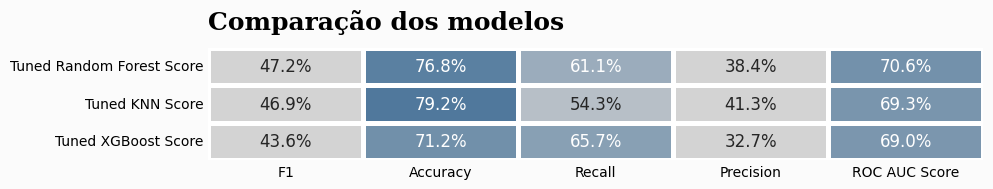

In [17]:
df_models = round(pd.concat([rf_df_tuned,knn_df_tuned,xgb_df_tuned], axis=1),6)
colors = ["lightgray","lightgray","#0f4c81"]
colormap = matplotlib.colors.LinearSegmentedColormap.from_list("", colors)

background_color = "#fbfbfb"

fig = plt.figure(figsize=(10,8)) # create figure
gs = fig.add_gridspec(4, 2)
gs.update(wspace=0.1, hspace=0.5)
ax0 = fig.add_subplot(gs[0, :])

sns.heatmap(df_models.T, cmap=colormap,annot=True,fmt=".1%",vmin=0,vmax=0.95, linewidths=2.5,cbar=False,ax=ax0,annot_kws={"fontsize":12})
fig.patch.set_facecolor(background_color) # figure background color
ax0.set_facecolor(background_color) 

ax0.text(0,-0.5,'Comparação dos modelos',fontsize=18,fontweight='bold',fontfamily='serif')
ax0.tick_params(axis=u'both', which=u'both',length=0)


plt.show()

## "Dropando" features 

Para uma maior completude dos testes, vamos remover as features menos relacionadas à variável 'abandono' identificadas na análise dos dados e ver se há uma melhora dos resultados. São elas: região de notificação (reg_not), agravo de doenças mentais (agravdoenc) e beneficiário de programa de transferência de renda do governo (benef_gov).

In [8]:
# Dropando as colunas
X_train_resh_2 = X_train_resh.drop(['reg_not','agravdoenc','benef_gov'], axis=1)
X_test_2 = X_test.drop(['reg_not','agravdoenc','benef_gov'], axis=1)

rf_pipeline_tuned = Pipeline(steps = [('scale',StandardScaler()),('classifier',RandomForestClassifier(min_samples_leaf=2, min_samples_split=5, n_estimators=200, random_state=42))])
rf_pipeline_tuned.fit(X_train_resh_2,y_train_resh)
rf_tuned_pred_2 = rf_pipeline_tuned.predict(X_test_2)
rf_tuned_cm_2 = confusion_matrix(y_test,rf_tuned_pred_2)
rf_tuned_f1_2 = f1_score(y_test,rf_tuned_pred_2)
print('RF mean :',rf_tuned_f1_2)
print("======== Random Forest ========")
print(rf_tuned_cm_2)
print(classification_report(y_test,rf_tuned_pred_2))
print('Accuracy Score: ',accuracy_score(y_test,rf_tuned_pred_2))


RF mean : 0.4306239040669721
======== Random Forest ========
[[45373 15336]
 [ 4796  7613]]
              precision    recall  f1-score   support

           0       0.90      0.75      0.82     60709
           1       0.33      0.61      0.43     12409

    accuracy                           0.72     73118
   macro avg       0.62      0.68      0.62     73118
weighted avg       0.81      0.72      0.75     73118

Accuracy Score:  0.7246642413632758


In [11]:
knn_pipeline_tuned = Pipeline(steps = [('scale',StandardScaler()),('classifier',KNeighborsClassifier(n_neighbors=9, metric='euclidean', weights='distance'))])
knn_pipeline_tuned.fit(X_train_resh_2,y_train_resh)
knn_tuned_pred_2 = knn_pipeline_tuned.predict(X_test_2)
knn_tuned_cm_2 = confusion_matrix(y_test,knn_tuned_pred_2)
knn_tuned_f1_2 = f1_score(y_test,knn_tuned_pred_2)
print('KNN mean :',knn_tuned_f1_2)
print("======== KNN ========")
print(knn_tuned_cm_2)
print(classification_report(y_test,knn_tuned_pred_2))
print('Accuracy Score: ',accuracy_score(y_test,knn_tuned_pred_2))

KNN mean : 0.41883673787618897
======== KNN ========
[[52838  7871]
 [ 7037  5372]]
              precision    recall  f1-score   support

           0       0.88      0.87      0.88     60709
           1       0.41      0.43      0.42     12409

    accuracy                           0.80     73118
   macro avg       0.64      0.65      0.65     73118
weighted avg       0.80      0.80      0.80     73118

Accuracy Score:  0.796110396892694


In [33]:
xgb_pipeline_tuned = Pipeline(steps = [('scale',StandardScaler()),('classifier',XGBClassifier(learning_rate=0.1, max_depth=9, n_estimators=50, subsample=0.6, random_state=42))])
xgb_pipeline_tuned.fit(X_train_resh_2,y_train_resh)
xgb_tuned_pred_2 = xgb_pipeline_tuned.predict(X_test_2)
xgb_tuned_cm_2 = confusion_matrix(y_test,xgb_tuned_pred_2)
xgb_tuned_f1_2 = f1_score(y_test,xgb_tuned_pred_2)
print('XGB mean :',xgb_tuned_f1_2)
print("======== XGBoost ========")
print(xgb_tuned_cm_2)
print(classification_report(y_test,xgb_tuned_pred_2))
print('Accuracy Score: ',accuracy_score(y_test,xgb_tuned_pred_2))

XGB mean : 0.4367340525819629
======== XGBoost ========
[[43269 17440]
 [ 4070  8339]]
              precision    recall  f1-score   support

           0       0.91      0.71      0.80     60709
           1       0.32      0.67      0.44     12409

    accuracy                           0.71     73118
   macro avg       0.62      0.69      0.62     73118
weighted avg       0.81      0.71      0.74     73118

Accuracy Score:  0.705817992833502


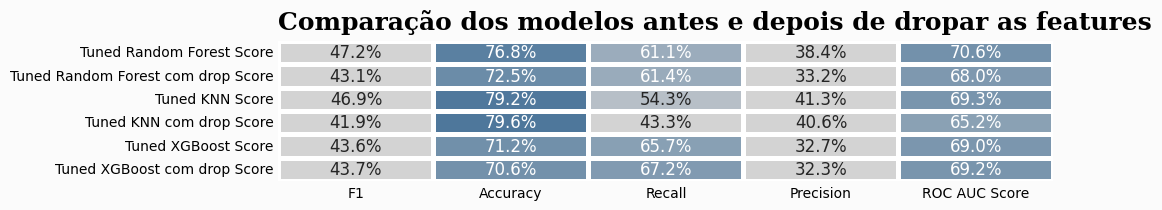

In [34]:
rf_df_tuned_dropped = pd.DataFrame(data=[f1_score(y_test,rf_tuned_pred_2),accuracy_score(y_test, rf_tuned_pred_2), recall_score(y_test, rf_tuned_pred_2),
                   precision_score(y_test, rf_tuned_pred_2), roc_auc_score(y_test, rf_tuned_pred_2)], 
             columns=['Tuned Random Forest com drop Score'],
             index=["F1","Accuracy", "Recall", "Precision", "ROC AUC Score"])

knn_df_tuned_dropped = pd.DataFrame(data=[f1_score(y_test,knn_tuned_pred_2),accuracy_score(y_test, knn_tuned_pred_2), recall_score(y_test, knn_tuned_pred_2),
                   precision_score(y_test, knn_tuned_pred_2), roc_auc_score(y_test, knn_tuned_pred_2)], 
             columns=['Tuned KNN com drop Score'],
             index=["F1","Accuracy", "Recall", "Precision", "ROC AUC Score"])

xgb_df_tuned_dropped = pd.DataFrame(data=[f1_score(y_test,xgb_tuned_pred_2),accuracy_score(y_test, xgb_tuned_pred_2), recall_score(y_test, xgb_tuned_pred_2),
                   precision_score(y_test, xgb_tuned_pred_2), roc_auc_score(y_test, xgb_tuned_pred_2)], 
             columns=['Tuned XGBoost com drop Score'],
             index=["F1","Accuracy", "Recall", "Precision", "ROC AUC Score"])

df_models = round(pd.concat([rf_df_tuned,rf_df_tuned_dropped,knn_df_tuned,knn_df_tuned_dropped,xgb_df_tuned,xgb_df_tuned_dropped], axis=1),6)
colors = ["lightgray","lightgray","#0f4c81"]
colormap = matplotlib.colors.LinearSegmentedColormap.from_list("", colors)

background_color = "#fbfbfb"

fig = plt.figure(figsize=(10,10)) # create figure
gs = fig.add_gridspec(4, 2)
gs.update(wspace=0.1, hspace=0.5)
ax0 = fig.add_subplot(gs[0, :])

sns.heatmap(df_models.T, cmap=colormap,annot=True,fmt=".1%",vmin=0,vmax=0.95, linewidths=2.5,cbar=False,ax=ax0,annot_kws={"fontsize":12})
fig.patch.set_facecolor(background_color) # figure background color
ax0.set_facecolor(background_color) 

ax0.text(0,-0.5,'Comparação dos modelos antes e depois de dropar as features',fontsize=18,fontweight='bold',fontfamily='serif')
ax0.tick_params(axis=u'both', which=u'both',length=0)


plt.show()

Observa-se que após remover as features citadas, os resultados das predições dos modelos Random Forest e KNN pioraram e, por mais que o resultado do XGBoost tenha ligeiramente piorado para as métricas de acurácia e precision, houve melhora do F1, do recall e da ROC AUC.

## Escolha do melhor modelo

Para escolher um modelo, precisamos julgar quais métricas são mais importantes no nosso caso.  
Nós queremos prever as pessoas com tuberculose com maior chance de abandonar o tratamento para que medidas preventivas possam ser tomadas. Assim, devemos priorizar um maior Recall.  
Ao analisar as métricas dos modelos no quadro acima, percebemos que o Tuned XGBoost treinado no dataset balanceado e com certas features removidas apresenta o maior Recall e, por mais que possua menores valores de Acurácia, Precisão, F1 e ROC AUC comparado a outros modelos, não é uma diferença comprometedora, assim, avaliamos que ele é o mais apropriado para o problema.

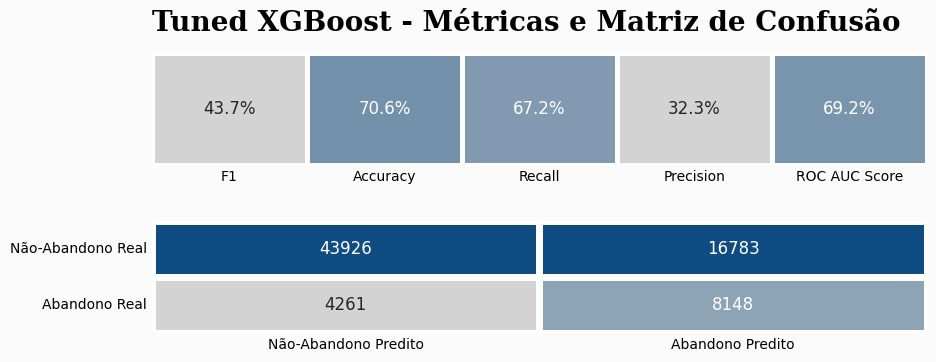

In [35]:
colors = ["lightgray","lightgray","#0f4c81"]
colormap = matplotlib.colors.LinearSegmentedColormap.from_list("", colors)

background_color = "#fbfbfb"

fig = plt.figure(figsize=(10,8)) # create figure
gs = fig.add_gridspec(4, 2)
gs.update(wspace=0.1, hspace=0.5)
ax0 = fig.add_subplot(gs[0, :])
ax1 = fig.add_subplot(gs[1, :])

sns.heatmap(xgb_df_tuned_dropped.T, cmap=colormap,annot=True,fmt=".1%",vmin=0,vmax=0.95,yticklabels='', linewidths=2.5,cbar=False,ax=ax0,annot_kws={"fontsize":12})
fig.patch.set_facecolor(background_color) # figure background color
ax0.set_facecolor(background_color) 
ax1.set_facecolor(background_color) 

ax0.text(0,-0.2,'Tuned XGBoost - Métricas e Matriz de Confusão',fontsize=20,fontweight='bold',fontfamily='serif')
ax0.tick_params(axis=u'both', which=u'both',length=0)



# Overall

sns.heatmap(xgb_tuned_cm, cmap=colormap,annot=True,fmt="d", linewidths=5,cbar=False,ax=ax1,
            yticklabels=['Não-Abandono Real','Abandono Real'],vmax=12000,vmin=0,xticklabels=['Não-Abandono Predito','Abandono Predito'],annot_kws={"fontsize":12})
ax0.tick_params(axis=u'both', which=u'both',length=0)
ax1.tick_params(axis=u'both', which=u'both',length=0)
plt.show()